# Weekday/Weekend/Holiday Comparative Analysis

This notebook provides a concise comparison of coffee sales data across weekdays, weekends, and holidays, focusing on three core metrics:
1. Sales Comparison: Using average values to ensure fair comparison
2. Popular Coffee Comparison: Coffee preferences across different day types
3. Average Order Value Statistics: Analysis of transaction amounts


## 1. Data Preparation


In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import warnings
warnings.filterwarnings('ignore')

# Set font and style
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

# Load data
df = pd.read_csv('upload/index_1.csv')
print(f"Data loaded successfully! Total {len(df)} records")


Data loaded successfully! Total 3636 records


### Data Preprocessing


In [11]:
# Convert date and time format
df['date'] = pd.to_datetime(df['date'])
df['datetime'] = pd.to_datetime(df['datetime'])
df['weekday'] = df['datetime'].dt.weekday  # 0=Monday, 6=Sunday

# Define US public holidays and classify day types
us_holidays = holidays.US(years=[2024, 2025])

def classify_day_type(row):
    date = row['date']
    weekday = row['weekday']
    if date.date() in us_holidays:
        return 'Holiday'
    elif weekday >= 5:  # 5=Saturday, 6=Sunday
        return 'Weekend'
    else:
        return 'Weekday'

df['day_type'] = df.apply(classify_day_type, axis=1)

print("Day type classification completed!")
print(f"\nData distribution:")
print(df['day_type'].value_counts())
print(f"\nDate range: {df['date'].min().date()} to {df['date'].max().date()}")


Day type classification completed!

Data distribution:
day_type
Weekday    2614
Weekend     916
Holiday     106
Name: count, dtype: int64

Date range: 2024-03-01 to 2025-03-23


In [13]:
# Calculate daily statistics (for computing averages)
daily_sales = df.groupby(['date', 'day_type']).agg({
    'money': ['sum', 'count']
}).reset_index()
daily_sales.columns = ['date', 'day_type', 'total_sales', 'order_count']


## 2. Section 1: Weekend/Weekday/Holiday Sales Comparison

**Using average values for fair comparison** (since weekday count is much higher than weekend and holiday)


In [14]:
# Calculate average sales metrics by day type
avg_stats = daily_sales.groupby('day_type').agg({
    'total_sales': 'mean',  # Average daily sales
    'order_count': 'mean'   # Average daily order count
}).round(2)

# Get day count statistics
day_counts = daily_sales['day_type'].value_counts()

print("=" * 60)
print("Average Sales Metrics by Day Type")
print("=" * 60)
for day_type in ['Weekday', 'Weekend', 'Holiday']:
    if day_type in avg_stats.index:
        print(f"\n{day_type}:")
        print(f"  Total days: {day_counts[day_type]} days")
        print(f"  Average daily sales: ${avg_stats.loc[day_type, 'total_sales']:.2f}")
        print(f"  Average daily orders: {avg_stats.loc[day_type, 'order_count']:.1f} orders")
print("=" * 60)


Average Sales Metrics by Day Type

Weekday:
  Total days: 262 days
  Average daily sales: $316.69
  Average daily orders: 10.0 orders

Weekend:
  Total days: 109 days
  Average daily sales: $266.43
  Average daily orders: 8.4 orders

Holiday:
  Total days: 10 days
  Average daily sales: $341.72
  Average daily orders: 10.6 orders


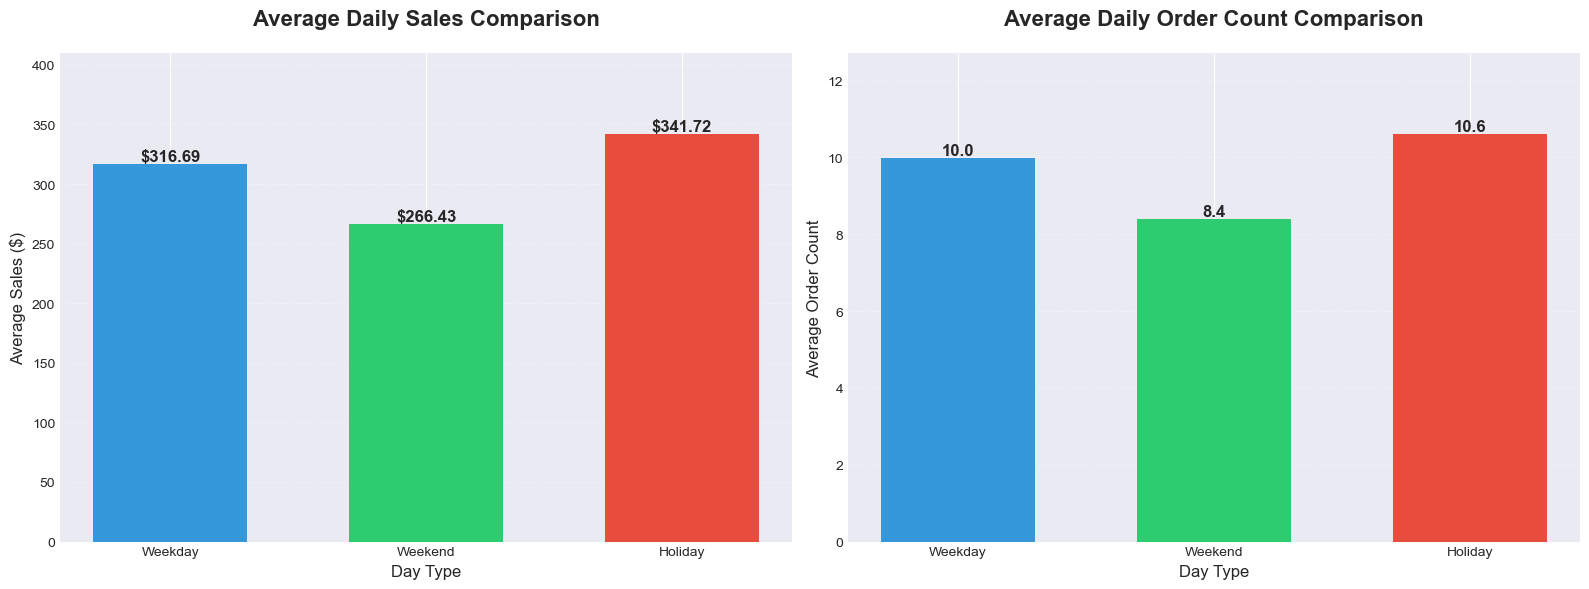

In [15]:
# Visualization: Average sales and order count comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Average daily sales comparison
day_type_order = ['Weekday', 'Weekend', 'Holiday']
colors = ['#3498db', '#2ecc71', '#e74c3c']
avg_sales = avg_stats.loc[day_type_order, 'total_sales']

bars1 = axes[0].bar(day_type_order, avg_sales, color=colors, width=0.6)
axes[0].set_title('Average Daily Sales Comparison', fontsize=16, fontweight='bold', pad=20)
axes[0].set_ylabel('Average Sales ($)', fontsize=12)
axes[0].set_xlabel('Day Type', fontsize=12)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_ylim(0, max(avg_sales) * 1.2)

# Add value labels
for bar, value in zip(bars1, avg_sales):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'${value:.2f}',
                ha='center', va='bottom', fontweight='bold', fontsize=12)

# 2. Average daily order count comparison
avg_orders = avg_stats.loc[day_type_order, 'order_count']

bars2 = axes[1].bar(day_type_order, avg_orders, color=colors, width=0.6)
axes[1].set_title('Average Daily Order Count Comparison', fontsize=16, fontweight='bold', pad=20)
axes[1].set_ylabel('Average Order Count', fontsize=12)
axes[1].set_xlabel('Day Type', fontsize=12)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].set_ylim(0, max(avg_orders) * 1.2)

# Add value labels
for bar, value in zip(bars2, avg_orders):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.1f}',
                ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()


## 3. Section 2: Weekend/Weekday/Holiday Popular Coffee Comparison

**Using percentages to show coffee preferences by day type**


In [16]:
# Calculate coffee sales volume and percentage by day type
coffee_stats = df.groupby(['day_type', 'coffee_name']).size().reset_index(name='count')
total_by_day = df.groupby('day_type').size().reset_index(name='total')
coffee_stats = coffee_stats.merge(total_by_day, on='day_type')
coffee_stats['percentage'] = (coffee_stats['count'] / coffee_stats['total'] * 100).round(2)

# Get Top 5 coffees for each day type
print("=" * 70)
print("Top 5 Popular Coffees by Day Type")
print("=" * 70)

top_coffees = {}
for day_type in ['Weekday', 'Weekend', 'Holiday']:
    data = coffee_stats[coffee_stats['day_type'] == day_type].sort_values('count', ascending=False).head(5)
    top_coffees[day_type] = data
    print(f"\n{day_type}:")
    for idx, row in data.iterrows():
        print(f"  {row['coffee_name']:25s} - {row['count']:4d} orders ({row['percentage']:5.2f}%)")
print("=" * 70)


Top 5 Popular Coffees by Day Type

Weekday:
  Americano with Milk       -  577 orders (22.07%)
  Latte                     -  570 orders (21.81%)
  Americano                 -  438 orders (16.76%)
  Cappuccino                -  342 orders (13.08%)
  Hot Chocolate             -  211 orders ( 8.07%)

Weekend:
  Americano with Milk       -  224 orders (24.45%)
  Latte                     -  184 orders (20.09%)
  Cappuccino                -  142 orders (15.50%)
  Americano                 -  119 orders (12.99%)
  Cortado                   -  100 orders (10.92%)

Holiday:
  Latte                     -   28 orders (26.42%)
  Americano with Milk       -   23 orders (21.70%)
  Americano                 -   21 orders (19.81%)
  Cappuccino                -   17 orders (16.04%)
  Cocoa                     -    6 orders ( 5.66%)


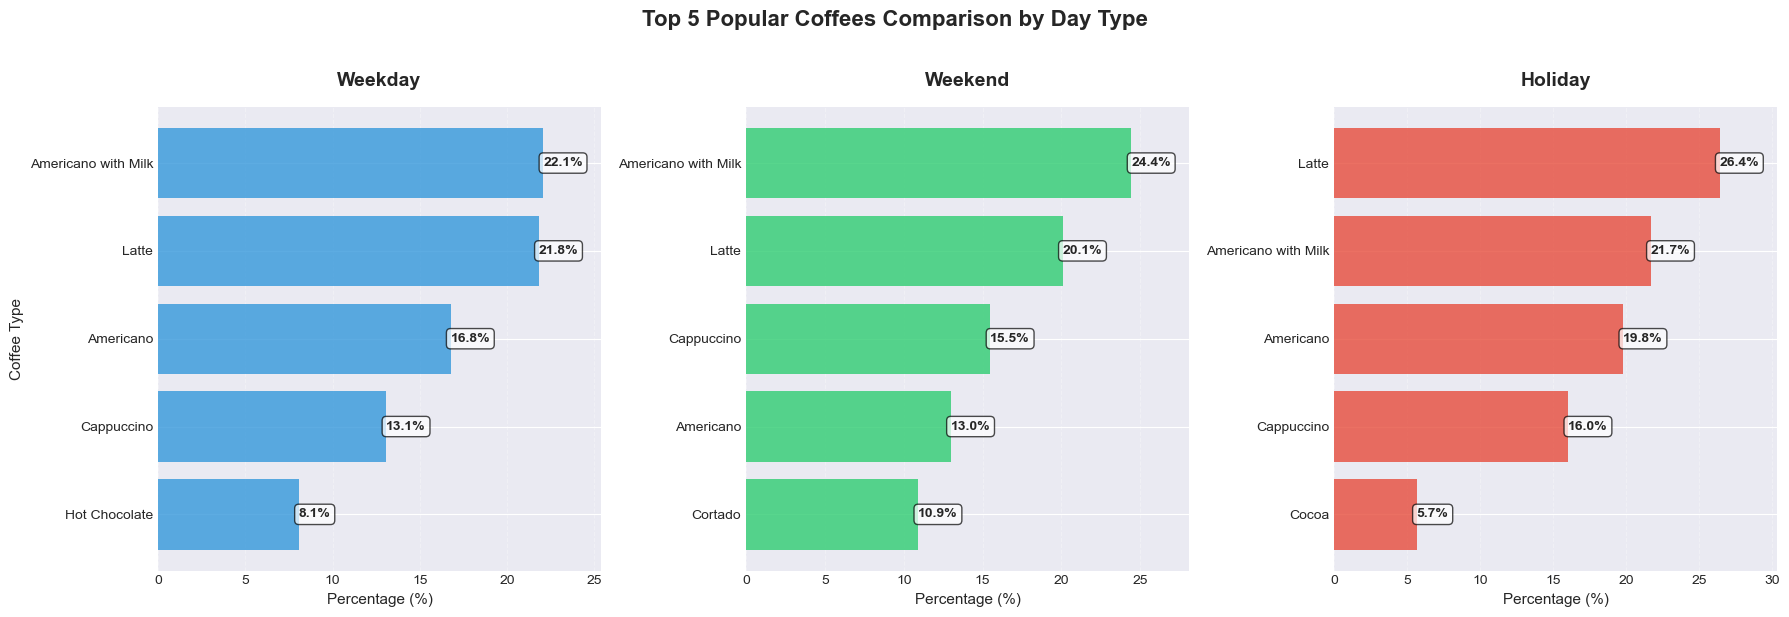

In [17]:
# Visualization: Side-by-side comparison of Top 5 coffees for each day type
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors_map = {'Weekday': '#3498db', 'Weekend': '#2ecc71', 'Holiday': '#e74c3c'}

for idx, day_type in enumerate(['Weekday', 'Weekend', 'Holiday']):
    data = top_coffees[day_type].sort_values('percentage', ascending=True)
    
    bars = axes[idx].barh(data['coffee_name'], data['percentage'], 
                          color=colors_map[day_type], alpha=0.8)
    axes[idx].set_title(f'{day_type}', fontsize=14, fontweight='bold', pad=15)
    axes[idx].set_xlabel('Percentage (%)', fontsize=11)
    axes[idx].grid(axis='x', alpha=0.3, linestyle='--')
    axes[idx].set_xlim(0, max(data['percentage']) * 1.15)
    
    # Add percentage labels
    for bar, pct in zip(bars, data['percentage']):
        width = bar.get_width()
        axes[idx].text(width, bar.get_y() + bar.get_height()/2.,
                      f'{pct:.1f}%',
                      ha='left', va='center', fontweight='bold', fontsize=10, 
                      bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    if idx == 0:
        axes[idx].set_ylabel('Coffee Type', fontsize=11)

plt.suptitle('Top 5 Popular Coffees Comparison by Day Type', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 4. Section 3: Weekend/Weekday/Holiday Average Order Value Statistics

**Comparing average order value and distribution across day types**


In [18]:
# Calculate order value statistics by day type
avg_order_stats = df.groupby('day_type')['money'].agg([
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std Dev', 'std'),
    ('Min', 'min'),
    ('Max', 'max')
]).round(2)

print("=" * 60)
print("Order Value Statistics by Day Type")
print("=" * 60)
print(avg_order_stats)
print("=" * 60)


Order Value Statistics by Day Type
           Mean  Median  Std Dev    Min    Max
day_type                                      
Holiday   32.24   32.82     4.49  21.06  37.72
Weekday   31.74   32.82     4.91  18.12  40.00
Weekend   31.70   32.82     5.00  18.12  40.00


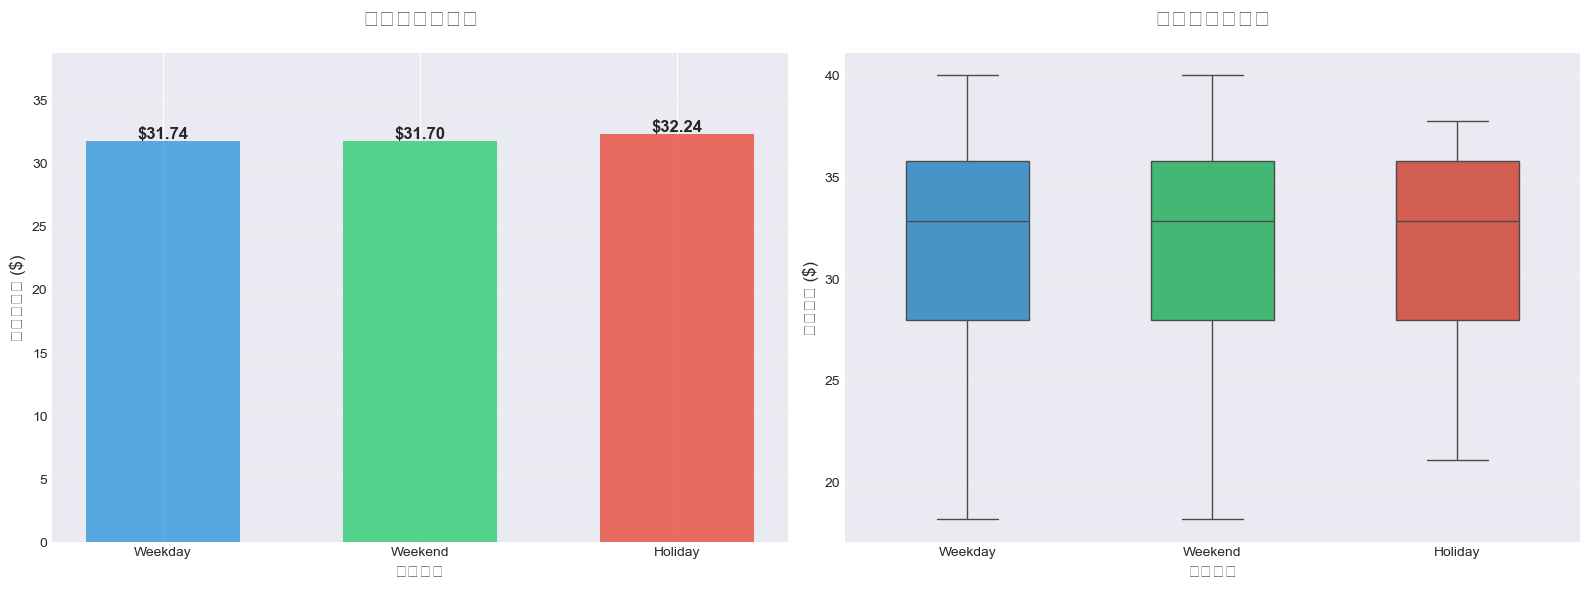


✓ Holiday的平均客单价最高($32.24)，Weekday和Weekend接近($31.74 vs $31.70)


In [ ]:
# Visualization: Order value comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

day_type_order = ['Weekday', 'Weekend', 'Holiday']
colors = ['#3498db', '#2ecc71', '#e74c3c']

# 1. Average order value bar chart
avg_prices = avg_order_stats.loc[day_type_order, 'Mean']
bars = axes[0].bar(day_type_order, avg_prices, color=colors, width=0.6, alpha=0.8)
axes[0].set_title('Average Order Value Comparison', fontsize=16, fontweight='bold', pad=20)
axes[0].set_ylabel('Average Order Value ($)', fontsize=12)
axes[0].set_xlabel('Day Type', fontsize=12)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_ylim(0, max(avg_prices) * 1.2)

# Add value labels
for bar, value in zip(bars, avg_prices):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'${value:.2f}',
                ha='center', va='bottom', fontweight='bold', fontsize=12)

# 2. Order value distribution box plot
sns.boxplot(data=df, x='day_type', y='money', order=day_type_order,
            palette=colors, ax=axes[1], width=0.5)
axes[1].set_title('Order Value Distribution', fontsize=16, fontweight='bold', pad=20)
axes[1].set_ylabel('Order Amount ($)', fontsize=12)
axes[1].set_xlabel('Day Type', fontsize=12)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()
